In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, DefaultOrbits, LISAModel, Space2050Model
from lisatools.utils.constants import *
from lisatools.sources import CalculationController, BBHCalculatorController
from lisatools.sources.emri import EMRIAETWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform

from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_97412/3433809864.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


## Define mission characteristics

In [2]:
missions = {}
lisamax_orbits = Orbits("lisamax_orbits.h5", armlength=2.59e+11)
lisa_max = Space2050Model(
    "space_2050_models/LISAmax_sensitivity_AET.csv", lisamax_orbits, "lisa_max"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["lisamax"] = dict(
    model=lisa_max,
    psd_kwargs=psd_kwargs
)

In [3]:
lisa_orbits = Orbits("lisa_orbits.h5", armlength=2.5e9)

lisa = Space2050Model(
    "space_2050_models/LISA_sensitivity_AET.csv", lisa_orbits, "lisa"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["lisa"] = dict(
    model=lisa,
    psd_kwargs=psd_kwargs
)

In [4]:
deci_orbits = Orbits("deci_orbits.h5", armlength=1e8)

deci = Space2050Model(
    "space_2050_models/DO_conservative_sensitivity_AET.csv", deci_orbits, "deci"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["deci"] = dict(
    model=deci,
    psd_kwargs=psd_kwargs
)

## Diagnostics

Setup all snr calculators

In [5]:
for mission in missions:
    print(mission)
    orbits_here = missions[mission]["model"].orbits
    # black hole generator
    bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=True))

    missions[mission]["bbh"] = BBHCalculatorController(
        bbh, missions[mission]["model"], missions[mission]["psd_kwargs"], psd=A1TDISens
    )
    
    # gb generator
    # gb = GBAETWaveform(orbits=orbits_here)

    # # emri generator
    # emri = EMRIAETWaveform(response_kwargs=dict(tdi="2nd generation", orbits=orbits_here))

    # # psd info

    # # fn = np.logspace(-6, -1, 1000)  # for plotting
    # # Sn = get_sensitivity(fn, sens_fn=A1TDISens, **psd_kwargs)  # for plotting

    # missions[mission]["bbh"] = CalculationController(bbh, missions[mission]["model"], missions[mission]["psd_kwargs"], psd=A1TDISens)

    # missions[mission]["emri"] = CalculationController(emri, missions[mission]["model"], missions[mission]["psd_kwargs"], psd=A1TDISens)

    # missions[mission]["gb"] = CalculationController(gb, missions[mission]["model"], missions[mission]["psd_kwargs"], psd=A1TDISens)

Tobs = YRSID_SI
dt = 10.0
Nobs = int(Tobs / dt)
Tobs = Nobs * dt
df = 1 / Tobs


lisamax
lisa
deci


### MBHBs

lisamax 268301.26793392084
lisa 3044.851520001097
deci 80.98301809218417


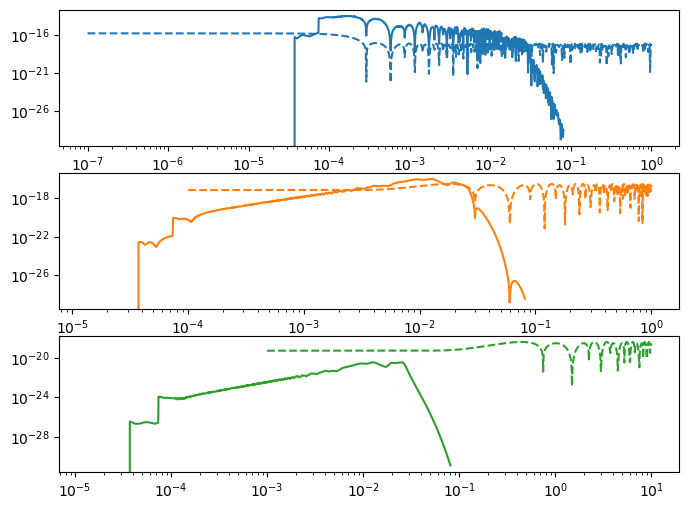

In [6]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.5  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["bbh"].get_snr(*mbh_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["bbh"].f_arr, np.abs(mission["bbh"].last_output[0]), c=f"C{i}")
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:686: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samp = np.random.multivariate_normal(params, cov, size=nsamp)


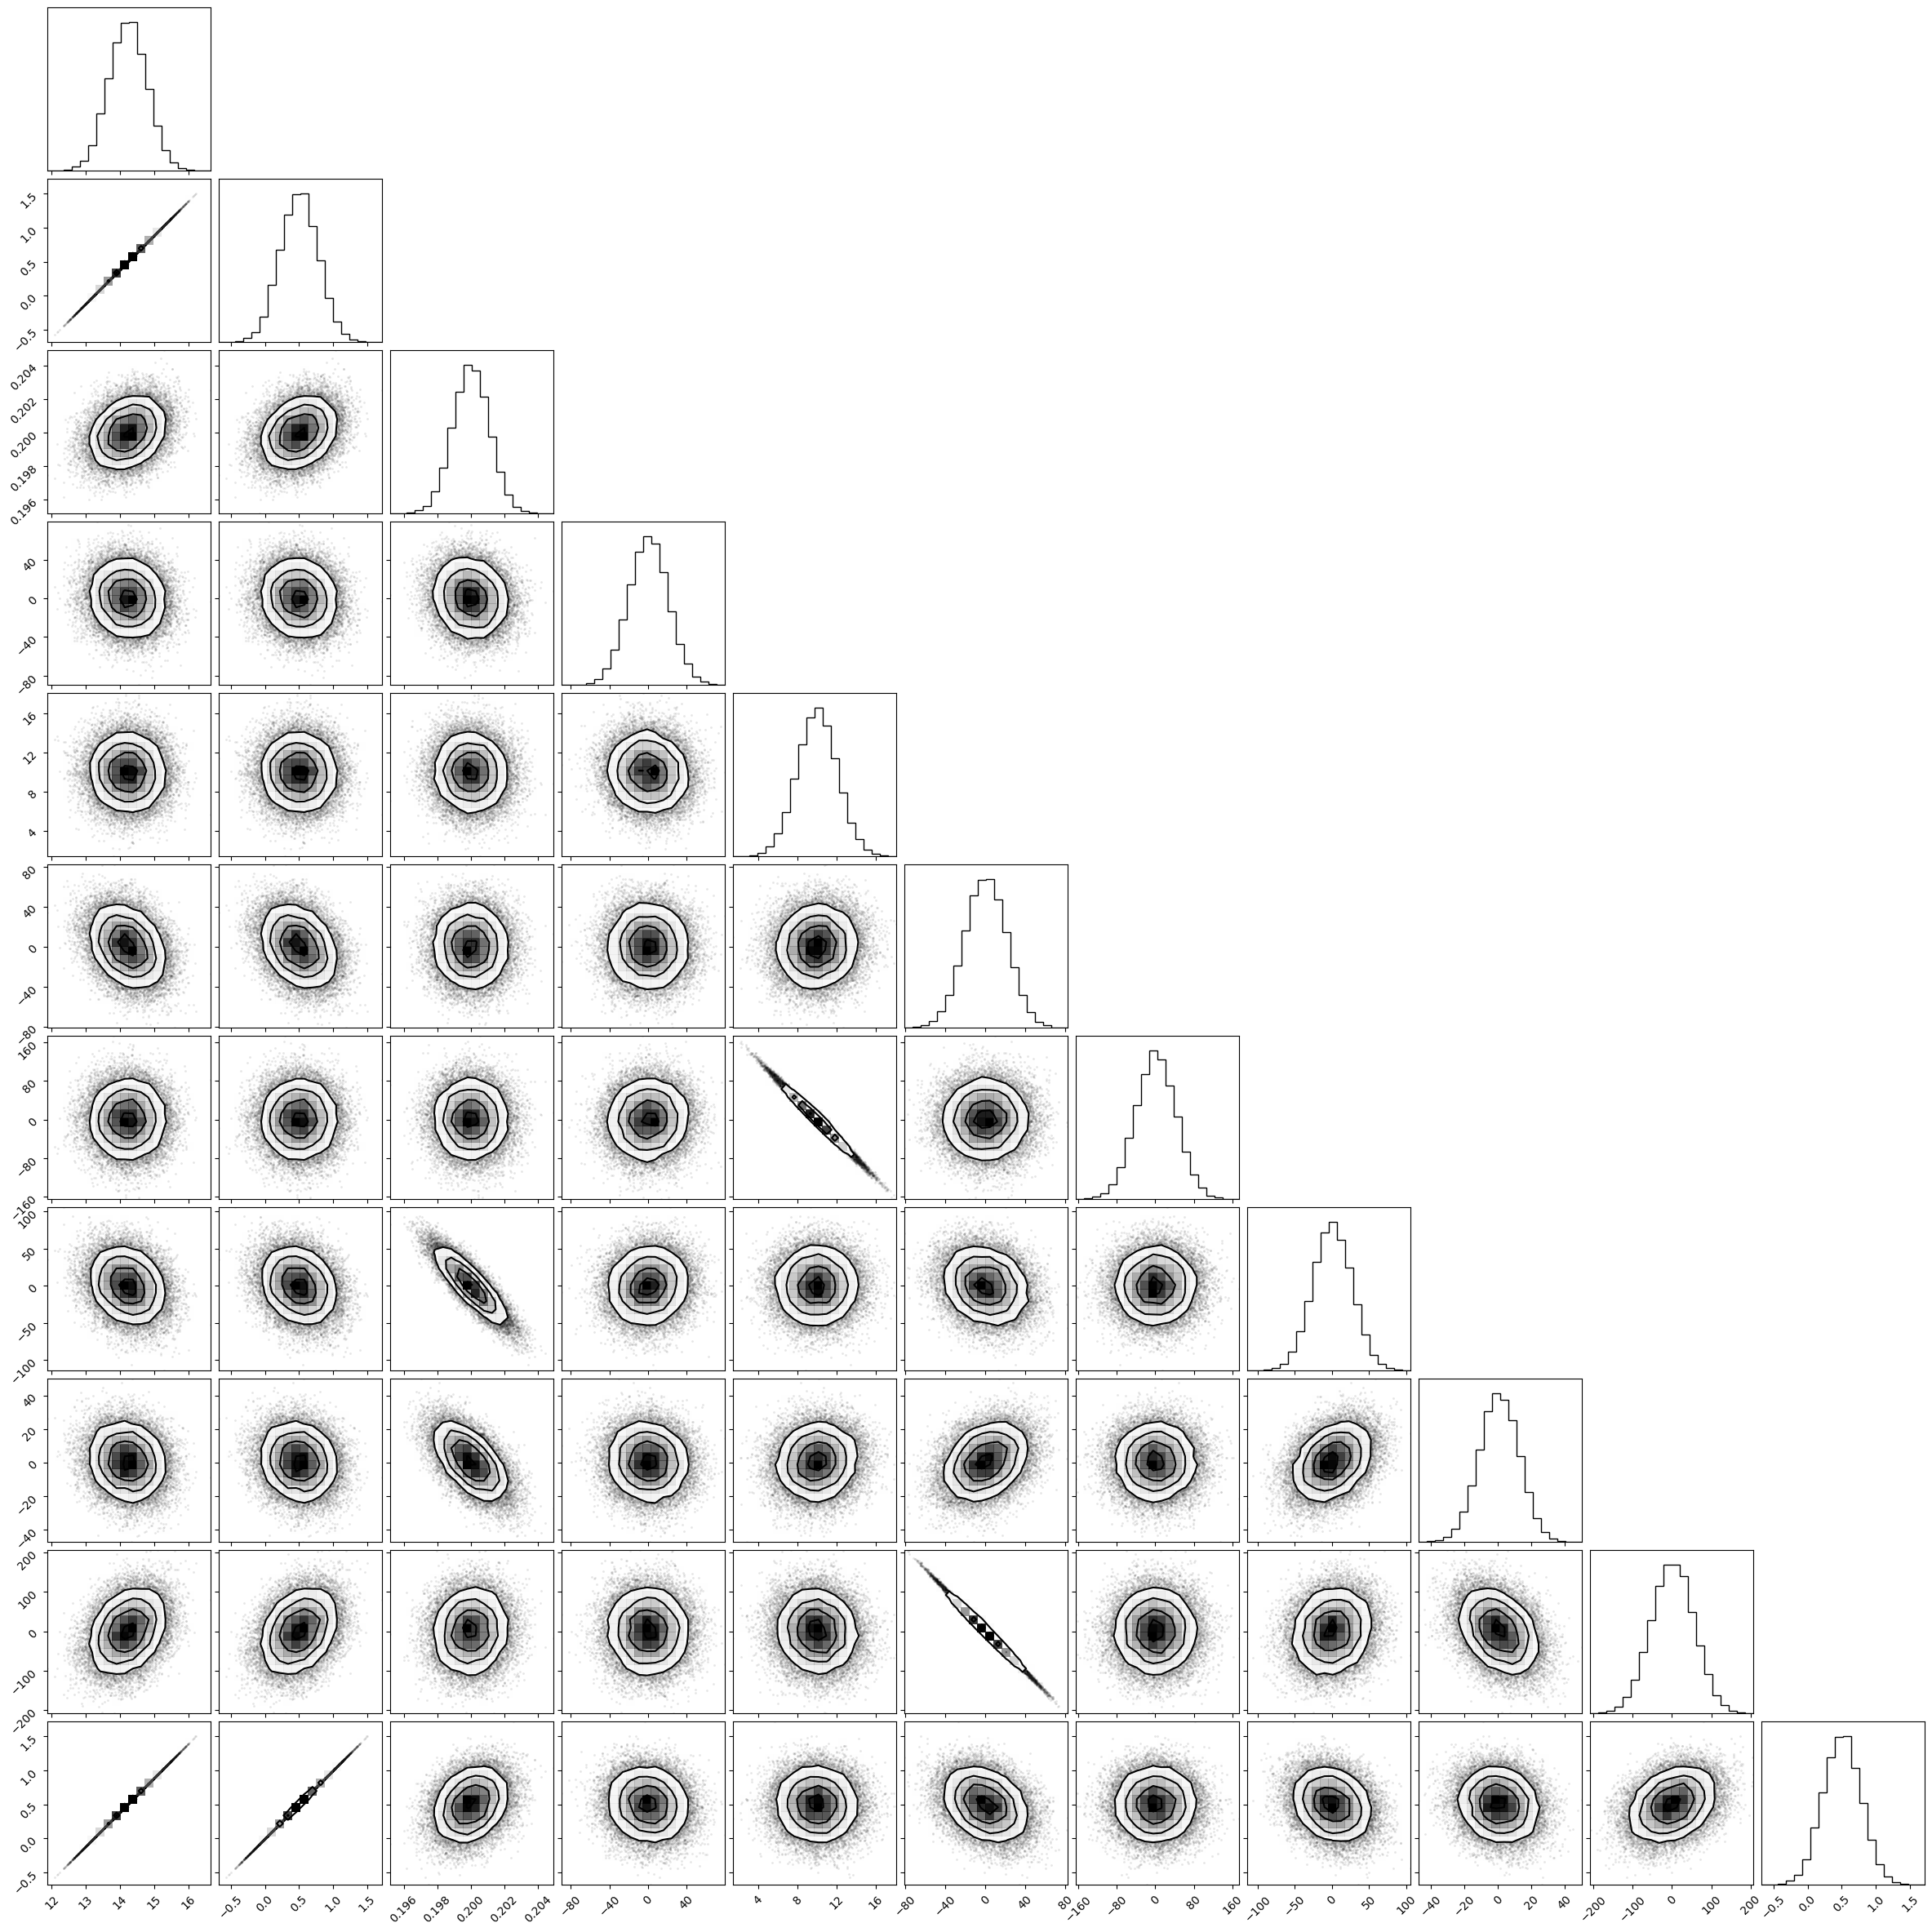

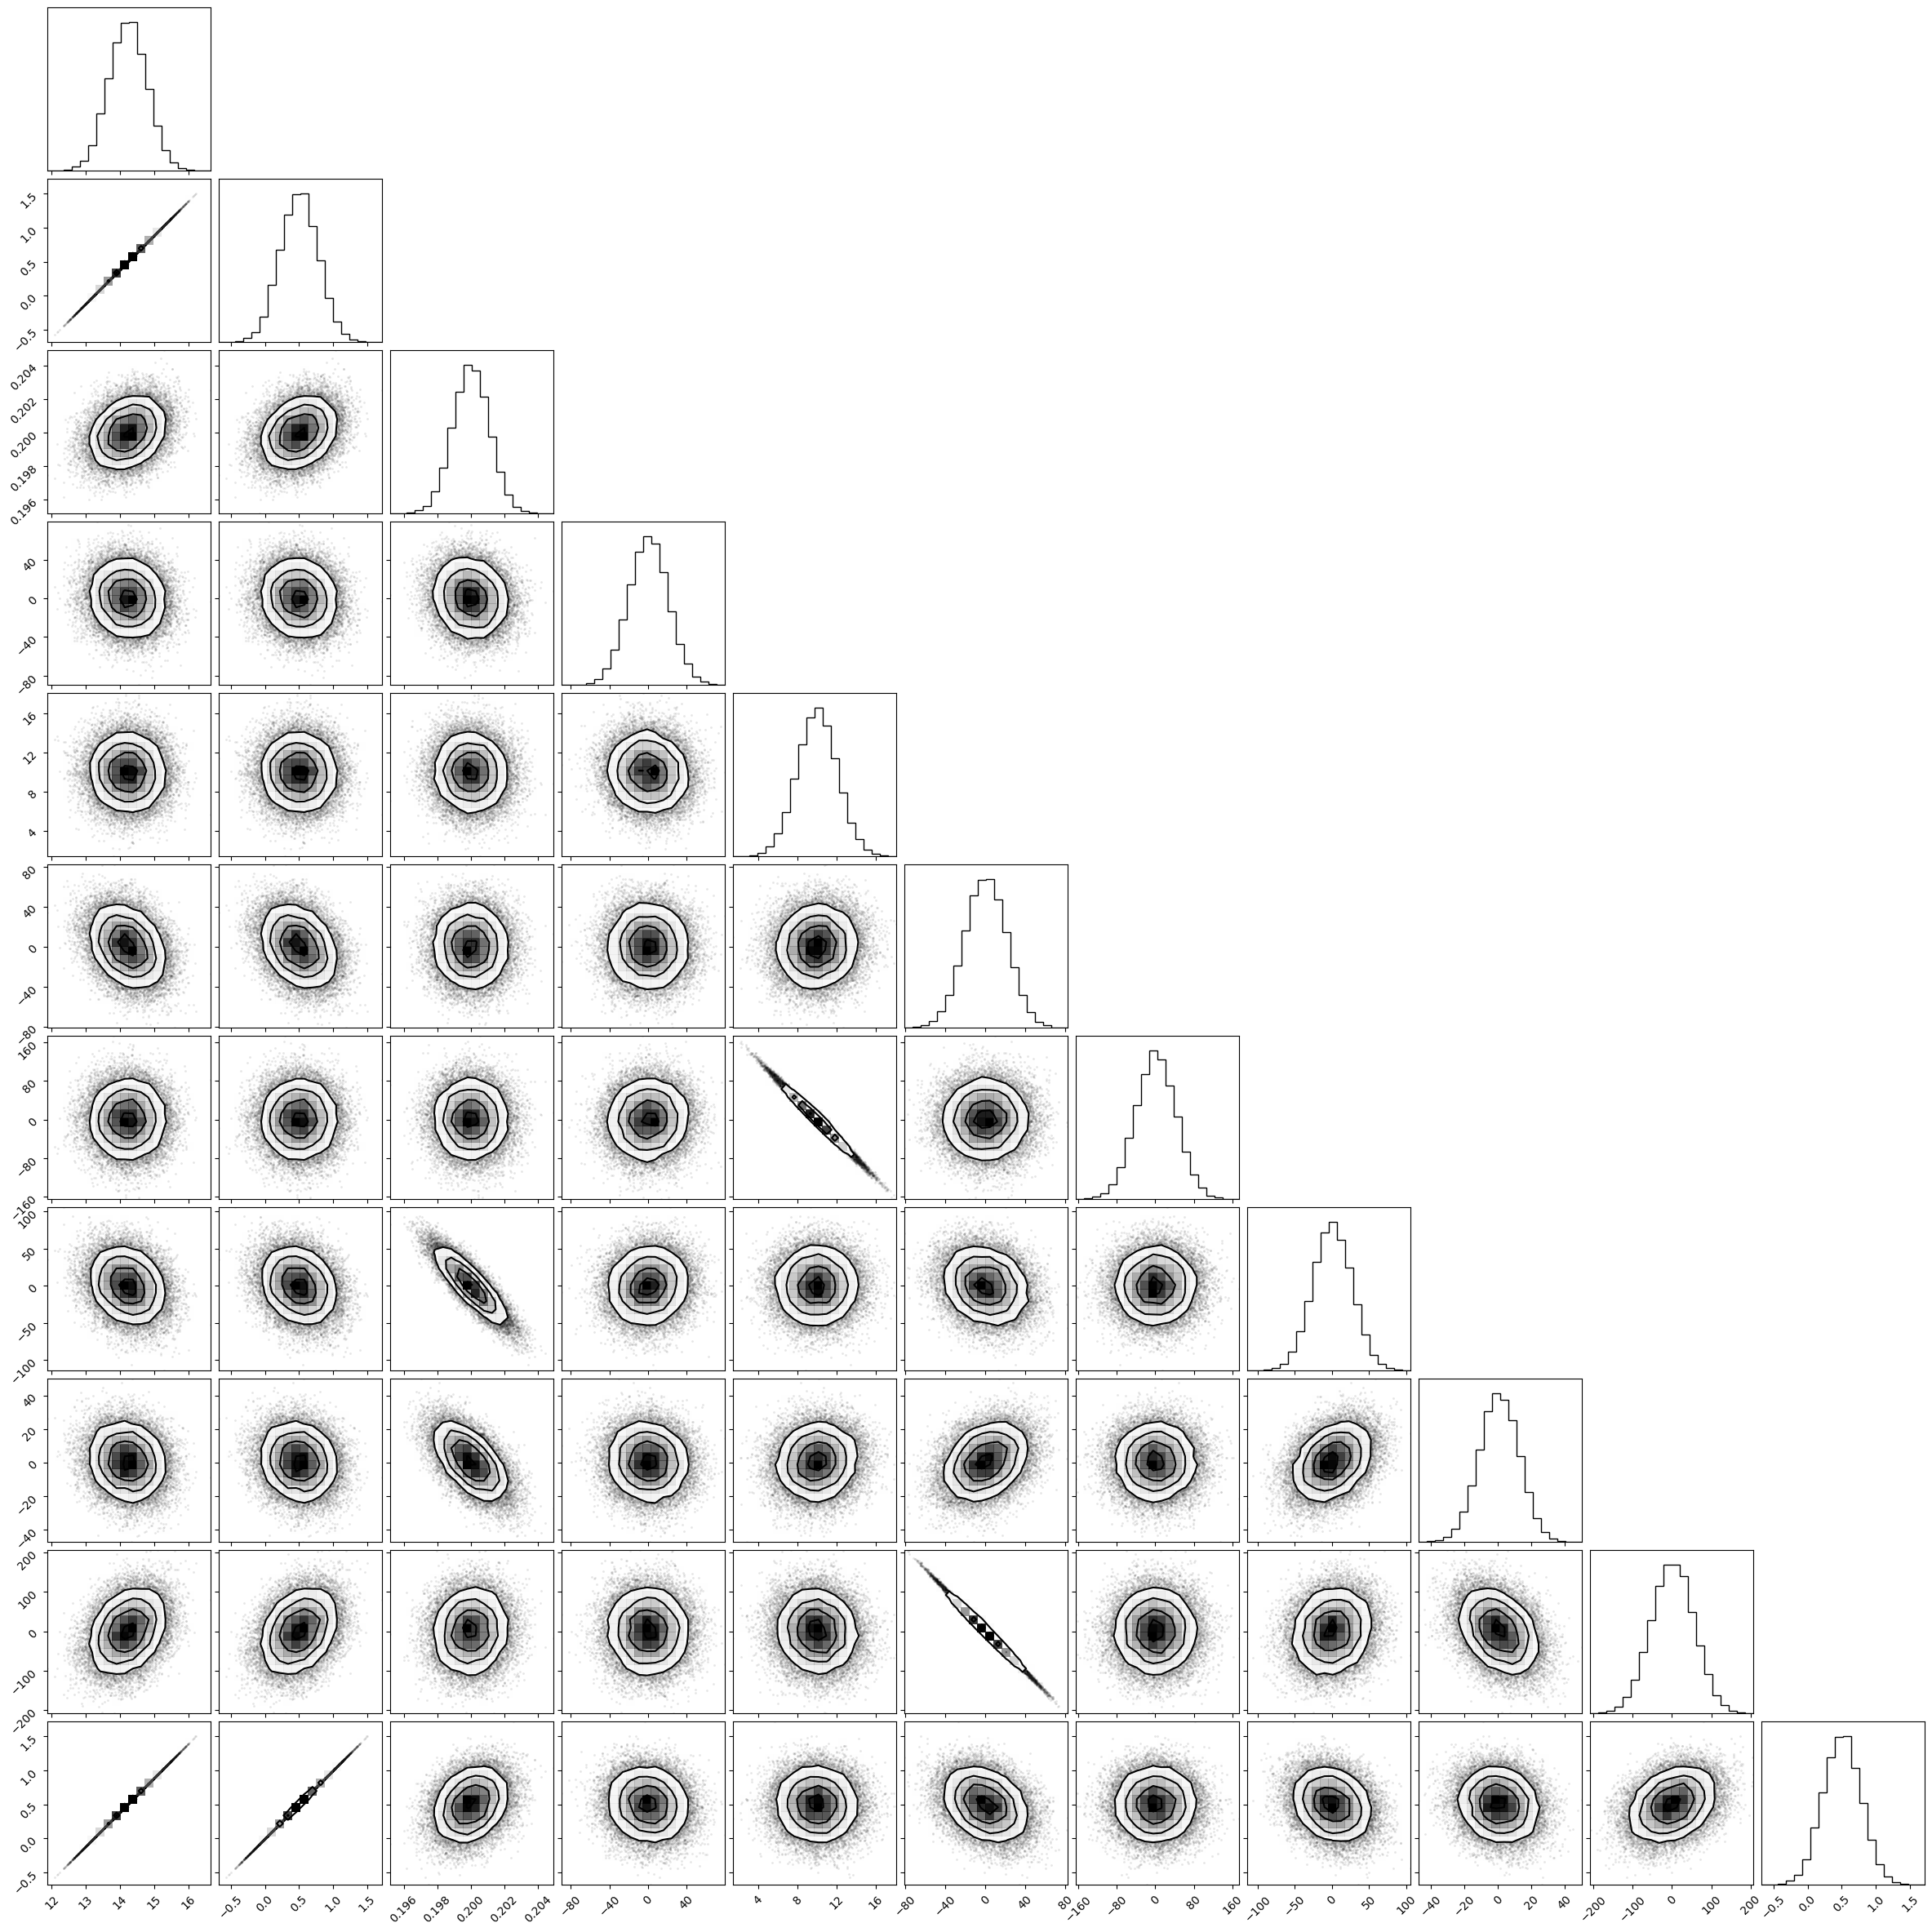

In [8]:
scaled_inj_params, cov = mission["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
    return_array=True,
)
plot_covariance_corner(scaled_inj_params, cov)

### GBs

lisamax 5780.558477641756
lisa 110.96683016855297
deci 0.9992019417168472


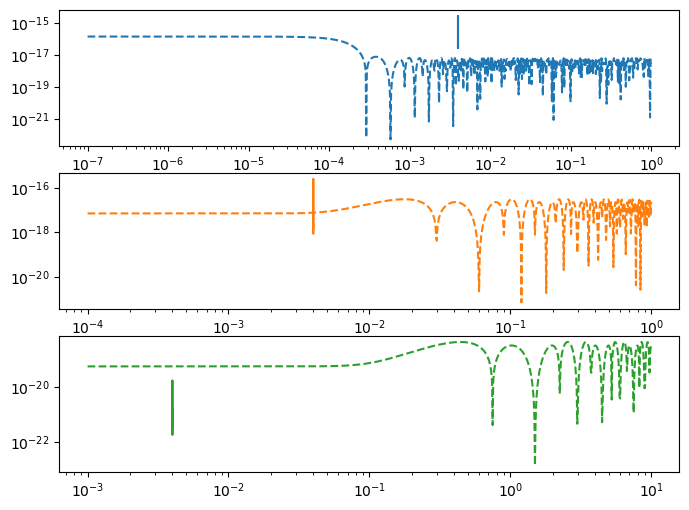

In [7]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["gb"](*gb_injection_params, tdi2=True))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")

#### VGBs Specifically

In [8]:
vgbs = pd.read_csv("vgbs.txt")

lisamax b'HPLib' 10092.719773581872
lisamax b'ZTFJ2320' 220.7366856043363
lisamax b'SDSSJ0923' 1619.7790188410702
lisamax b'AMCVn' 18060.204753838992
lisamax b'CX1751' 1901.2798517447004
lisamax b'ZTFJ2029' 1157.4171414722457
lisamax b'SDSSJ0935' 10002.852522818177
lisamax b'ZTFJ1539' 1882.0335278704101
lisamax b'SDSSJ2322' 4588.637863089688
lisamax b'4U1820-30' 302.2177248609369
lisamax b'HMCnc' 3814.0499429081046
lisamax b'CRBoo' 7815.637610145474
lisamax b'PTFJ0533' 1683.3801236165996
lisamax b'HD265435' 3679.63317306152
lisamax b'CDm30' 2592.635997752672
lisamax b'ZTFJ0640' 649.0779195871214
lisamax b'ZTFJ1749' 1764.0143378202843
lisamax b'SMSSJ0338' 3391.6388119137337
lisamax b'SDSSJ1630' 5739.773126880832
lisamax b'ZTFJ2055' 377.25480174272474
lisamax b'ZTFJ1901' 3119.2826811014515
lisamax b'ZTFJ1946' 744.1491344994856
lisamax b'ESCet' 5348.767841046085
lisamax b'SDSSJ1337' 14508.951133223867
lisamax b'ZTFJ2130' 2574.044038314225
lisamax b'V407Vul' 3218.4829025810513
lisamax b'ZT

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:376: RuntimeWarning: invalid value encountered in sqrt
  opt_snr = np.sqrt(inner_product(sig1, sig1, *args, **kwargs).real)


lisamax b'ZTFJ0538' nan
lisamax b'SDSSJ0651' 5041.433741090356
lisamax b'SDSSJ1908' 2115.99569609042
lisa b'HPLib' 16.271142028468507
lisa b'ZTFJ2320' 0.03665190684271332
lisa b'SDSSJ0923' 0.40466179301222266
lisa b'AMCVn' 29.59638821777864
lisa b'CX1751' 1.4605874681938267
lisa b'ZTFJ2029' 1.2521207711706102
lisa b'SDSSJ0935' 15.689706662226719
lisa b'ZTFJ1539' 57.17006670707132
lisa b'SDSSJ2322' 7.286856428218597
lisa b'4U1820-30' 3.7483094532392163
lisa b'HMCnc' 150.218961352577
lisa b'CRBoo' 5.545591123526762
lisa b'PTFJ0533' 1.998306019662957
lisa b'HD265435' 0.13783961173438108
lisa b'CDm30' 0.3287321598010109
lisa b'ZTFJ0640' 0.09569572309500342
lisa b'ZTFJ1749' 0.8155095742164497
lisa b'SMSSJ0338' 1.3501444713702477
lisa b'SDSSJ1630' 0.6865865905242797
lisa b'ZTFJ2055' 0.0608194334818138
lisa b'ZTFJ1901' 0.31234240838613075
lisa b'ZTFJ1946' 0.1816306608841104
lisa b'ESCet' 37.857814602923476
lisa b'SDSSJ1337' 0.26407264797394325
lisa b'ZTFJ2130' 0.33588365068231263
lisa b'V407V

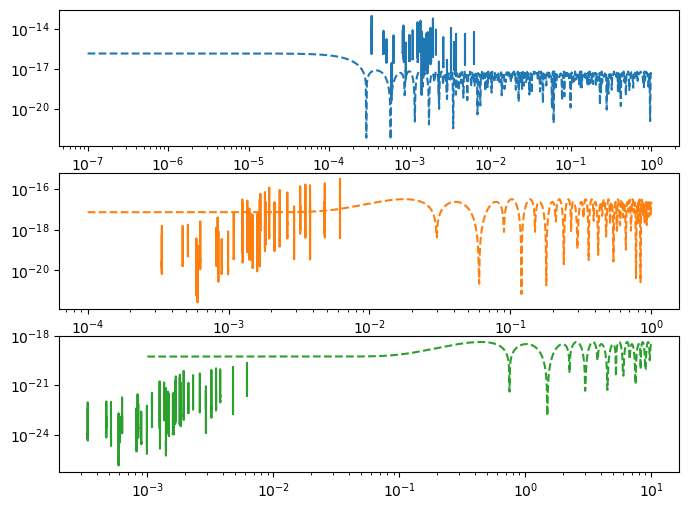

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
    for j in range(len(vgbs)):
        vgb = vgbs.iloc[j]
        params_in = np.array([
            vgb["Amplitude"],
            vgb["Frequency"],
            vgb["FrequencyDerivative"],
            0.0,
            vgb["InitialPhase"],
            vgb["Inclination"],
            vgb["Polarization"],
            vgb["EclipticLongitude"],
            vgb["EclipticLatitude"]
        ])
        print(name, vgb["Name"], mission["gb"](*params_in, tdi2=True))
        ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")

### EMRIs

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


lisamax 2035.039037532478
lisa 9.113170729386544
deci 45.43493554894104


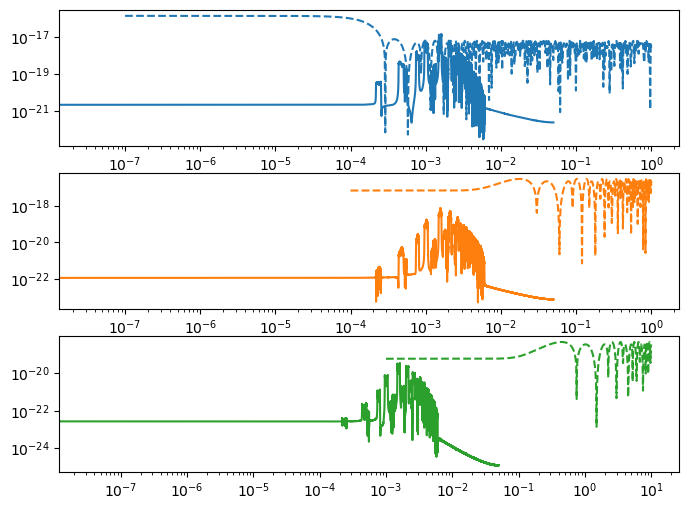

In [10]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["emri"](*emri_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    emri_freqs = np.fft.rfftfreq(mission["emri"].last_output[0].shape[0], mission["emri"].aet_template_gen.dt)
    ax[i].loglog(emri_freqs, np.abs(np.fft.rfft(mission["emri"].last_output[0])) * mission["emri"].aet_template_gen.dt, c=f"C{i}")
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
